In [1]:
# default_exp actorcritic.dads

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
#export
import torch.nn.utils as nn_utils
from fastai.torch_basics import *
import torch.nn.functional as F
from fastai.data.all import *
from fastai.basics import *
from dataclasses import field,asdict
from typing import List,Any,Dict,Callable
from collections import deque
import gym
import torch.multiprocessing as mp
from torch.optim import *
from dataclasses import dataclass

from fastrl.data import *
from fastrl.async_data import *
from fastrl.basic_agents import *
from fastrl.learner import *
from fastrl.metrics import *
from fastai.callback.progress import *
from fastrl.ptan_extension import *
from fastrl.actorcritic.sac import *
from fastrl.actorcritic.diayn import *

from torch.distributions import *

import matplotlib.pyplot as plt

if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

In [4]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# DADS

> Diversity Is All You Need

## GMM
> A neural net with a gaussian probability distribution component.

In [27]:
# export 
class OptionalClampLinear(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False,
                 clip_min=0.3,clip_max=10.0):
        "Linear layer or constant block used for std."
        store_attr()
        if self.fix_variance: self.fc=nn.Linear(self.num_inputs,self.state_dims)
    
    def forward(self,x):
        if self.fix_variance: return torch.full((x.shape[0],self.state_dims),1.0)
        else:                 return torch.clamp(nn.Softplus()(self.fc(x)))

class MultiCompGMM(Module):
    def __init__(self,num_inputs,state_dims,n_components,fix_variance:bool=False):
        "Multi-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.logit_fc=nn.Linear(self.num_inputs,self.n_components)
        self.mean_fcs=nn.ModuleList([nn.Linear(self.num_inputs,self.state_dims) for _ in range(self.n_components)])
        self.std_fcs=nn.ModuleList([OptionalClampLinear(self.num_inputs,self.state_dims,fix_variance) for _ in range(self.n_components)])
        self.distribution=None

    def forward(self,x):
        means=torch.stack([o(x) for o in self.mean_fcs],dim=1)
        stds=torch.stack([o(x) for o in self.std_fcs],dim=1)
        logits=self.logit_fc(x)
        return MixtureSameFamily(
            mixture_distribution=Categorical(logits),
            component_distribution=Independent(Normal(means,stds),1)
        )
    
class SimpleGMM(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False):
        "Single-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.mean_fc=nn.Linear(self.num_inputs,self.state_dims)
        self.std_fc=OptionalClampLinear(self.num_inputs,self.state_dims,fix_variance)
        
    def forward(self,x): return Independent(Normal(self.mean_fc(x),self.std_fc(x)),1)

class GMM(Module):
    def __init__(self,num_inputs,state_dims,n_components,fix_variance:bool=False):
        "N-component GMM parameterized by fully connected layers with optional std layers."
        store_attr()
        if self.n_components>1: self.distribution=MultiCompGMM(num_inputs,state_dims,n_components,fix_variance)
        else:                   self.distribution=SimpleGMM(num_inputs,state_dims,fix_variance)
        
    def forward(self,x): return self.distribution(x)

The GMM is going to try to predict the next state. So lets make a simple input to optimize against.
This test will be of a hot airballoon. Lets see if we can have a reasonable next state prediction.

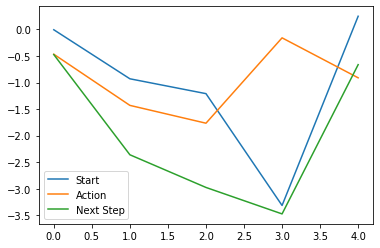

In [28]:
hot_air_ballon_start_states=torch.randn((5,1))
hot_air_ballon_start_actions=torch.randn((5,1))-0.5
hot_air_ballon_next_states=hot_air_ballon_start_states+hot_air_ballon_start_actions

plt.plot(hot_air_ballon_start_states.numpy(),label='Start')
plt.plot(hot_air_ballon_start_actions.numpy(),label='Action')
plt.plot(hot_air_ballon_next_states.numpy(),label='Next Step')
plt.legend()
plt.show()

In [29]:
gmm=GMM(2,1,2,fix_variance=True)
opt=Adam(gmm.parameters(),lr=0.001)

We have our GMM, so lets first see if we can get it to optimize to predict a next state...

In [30]:
next_timesteps=hot_air_ballon_next_states-hot_air_ballon_start_states

In [36]:
# def train(timesteps,actions,next_timesteps):
    
    

for step in range(10000):
    x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])

    dist=gmm(x)

    opt.zero_grad()
    loss=-torch.mean(dist.log_prob(next_timesteps))
    loss.backward()
    if step%1000==0:print(loss)
    opt.step()

tensor(1.8159, grad_fn=<NegBackward>)
tensor(0.9257, grad_fn=<NegBackward>)
tensor(0.9216, grad_fn=<NegBackward>)
tensor(0.9210, grad_fn=<NegBackward>)
tensor(0.9204, grad_fn=<NegBackward>)
tensor(0.9197, grad_fn=<NegBackward>)
tensor(0.9192, grad_fn=<NegBackward>)
tensor(0.9190, grad_fn=<NegBackward>)
tensor(0.9190, grad_fn=<NegBackward>)
tensor(0.9189, grad_fn=<NegBackward>)


In [37]:
hot_air_ballon_next_states

tensor([[-0.4743],
        [-2.3610],
        [-2.9763],
        [-3.4747],
        [-0.6640]])

In [38]:
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])
dist=gmm(x)

In [39]:
dist.mean

tensor([[-0.4675],
        [-1.4337],
        [-1.7644],
        [-0.1591],
        [-0.9034]], grad_fn=<SumBackward1>)

In [40]:
hot_air_ballon_start_states+dist.mean

tensor([[-0.4743],
        [-2.3639],
        [-2.9742],
        [-3.4748],
        [-0.6557]], grad_fn=<AddBackward0>)

In [ ]:
# export
class Discriminator(Module):
    "`Module` for storing skills. Receives input (`num_inputs`+`num_actions`) -> `num_skills`."
    def __init__(self, num_inputs,num_actions,num_skills,hidden_dim):
        self.linear1 = nn.Linear(num_inputs+num_skills, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim,num_skills)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state.float()))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [ ]:
# export
@delegates(SAC)
class DADS(SAC):
    def __init__(self,num_inputs,action_space,discriminator:Module=None,num_skills:int=20,
                 find_best_skill_interval:int=10,scale_entropy:float=1,
                 best_skill_n_rollouts:int=10,include_actions:bool=False,
                 learn_p_z:bool=False,add_p_z:bool=True,hidden_size=100,lr=0.003,**kwargs):
        store_attr()
        self.num_inputs=num_inputs+self.num_skills
        self.original_num_inputs=num_inputs
        self.p_z=np.full(self.num_skills,1.0/self.num_skills)
        self.discriminator=Discriminator(self.original_num_inputs,action_space.shape[0],
                                         num_skills,hidden_size)

        self.discriminator_optim = Adam(self.discriminator.parameters(), lr=self.lr)

        self.log_p_z_episode=[]
        self.z=0
        self.reset_z()


        super().__init__(self.num_inputs,action_space,hidden_size=hidden_size,lr=lr,**kwargs)

    def sample_z(self):
        """Samples z from p(z), using probabilities in self._p_z."""
        return np.random.choice(self.num_skills,p=self.p_z)

    def reset_z(self): self.z=self.sample_z()
    def __call__(self,s,asl):
        aug_s=self.concat_obs_z(s,self.z)
        return super().__call__(aug_s,asl)

    def concat_obs_z(self,obs,z):
        """Concatenates the observation to a one-hot encoding of Z."""
        assert np.isscalar(z)
        if type(obs)==list and len(obs)==1: obs=obs[0]
        if len(obs.shape)==2 and obs.shape[0]==1: obs=obs[0]

        z_one_hot=np.zeros(self.num_skills)
        z_one_hot[z]=1
        if type(obs)==Tensor: obs=obs.cpu()
        return torch.FloatTensor(np.hstack([obs,z_one_hot])).reshape(1,-1)

    def skill_p(self,skill,next_state):
        unnorm_skill_dist=self.discriminator(next_state).unsqueeze(0)
        skill_p=F.softmax(unnorm_skill_dist)[:,skill]
        return skill_p,unnorm_skill_dist

    def discriminator_learn(self,skill,out):
        self.discriminator_optim.zero_grad()
        loss=nn.CrossEntropyLoss()(out,torch.LongTensor([skill]))
        loss.backward()
        self.discriminator_optim.step()

    def intrinsic_reward(self,next_state):
        skill_p,disc_out=self.skill_p(self.z,next_state)
        intrinsic_reward=np.log(skill_p.cpu().detach()+1e-8)-np.log(self.p_z[self.z])
#         print(skill_p,self.p_z,intrinsic_reward)
        return intrinsic_reward,disc_out


In [ ]:
# export
class DiscriminatorTrainer(ExperienceReplay):

    def __init__(self,*args,**kwargs):
        self.log_p_z_episode=[]
        super().__init__(*args,**kwargs)
        
    def before_fit(self):
        self.learn.agent.warming_up=True
        while len(self.queue)<self.starting_els:
            for i,o in enumerate(self.dls.train):
                z=self.learn.agent.z
                batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(o[0][i],z)[0],
                                           action=o[1][i],
                                           reward=o[2][i],
                                           last_state=self.learn.agent.concat_obs_z(o[3][i],z)[0], 
                                           done=(o[4][i] and self.max_steps!=o[6][i]),
                                           episode_reward=o[5][i],steps=o[6][i])
                                    for i in range(len(o[0]))]
#                 print(self.max_steps,max([o.steps for o in batch]))
#                 print(batch[0])
                for k in range(len(batch)):
                    intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
                    self.learn.agent.discriminator_learn(self.agent.z,disc_out)
                    batch[k]=ExperienceFirstLast(
                        state=batch[k].state.to(device=default_device()),
                        action=batch[k].action,
                        reward=intrinsic_reward,
                        last_state=batch[k].last_state.to(device=default_device()),
                        done=batch[k].done,
                        episode_reward=batch[k].episode_reward,
                        steps=batch[k].steps
                    )


#                 print(batch[0])
                for _b in batch:self.queue.append(_b)
                if any([_b.done for _b in batch]): self.learn.agent.reset_z()
                if len(self.queue)>self.starting_els:break
        self.learn.agent.warming_up=False

# #     def after_epoch(self):
# #         print(len(self.queue))
    def before_batch(self):
#         print(len(self.queue))
        b=list(self.learn.xb)+list(self.learn.yb)
        z=self.learn.agent.z
        batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(b[0][i],z)[0],
                                   action=b[1][i],
                                   reward=b[2][i],
                                   last_state=self.learn.agent.concat_obs_z(b[3][i],z)[0], 
                                   done=(b[4][i] and self.max_steps!=b[6][i]),
                                   episode_reward=b[5][i],steps=b[6][i])
              for i in range(len(b[0]))]
        
        for k in range(len(batch)):
            intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
            self.learn.agent.discriminator_learn(self.agent.z,disc_out)
            batch[k]=ExperienceFirstLast(
                state=batch[k].state.to(device=default_device()),
                action=batch[k].action,
                reward=intrinsic_reward,
                last_state=batch[k].last_state.to(device=default_device()),
                done=batch[k].done,
                episode_reward=batch[k].episode_reward,
                steps=batch[k].steps
            )
        
#         print(self.learn.xb)
        self.learn.xb=(torch.stack([e.state for e in batch]),)
#         print(self.learn.yb)
        self.learn.yb=(torch.stack([o.action for o in batch]),
                       torch.stack([o.reward for o in batch]),
                       torch.stack([o.last_state for o in batch]),
                       torch.stack([o.done for o in batch]),
                       torch.stack([o.episode_reward for o in batch]),
                       torch.stack([o.steps for o in batch]))
#         print(self.learn.yb)
        
        for _b in batch: self.queue.append(_b)
        idxs=np.random.randint(0,len(self.queue), self.bs)
        self.learn.sample_yb=[self.queue[i] for i in idxs]

In [ ]:
from pybulletgym.envs import *

env='InvertedPendulumPyBulletEnv-v0'
agent=DADS(5,gym.make(env).action_space,gamma=0.99,tau=0.005,alpha=0.1,hidden_size=300,num_skills=5)
block=FirstLastExperienceBlock(agent=agent,seed=0,n_steps=2,exclude_nones=True,
                               dls_kwargs={'bs':1,'num_workers':0,'verbose':False,'indexed':True,'shuffle_train':False})
blk=IterableDataBlock(blocks=(block),splitter=FuncSplitter(lambda x:False))
dls=blk.dataloaders([env]*1,n=10,device=default_device())

learner=SACLearner(dls,agent=agent,cbs=[DiscriminatorTrainer(sz=1000000,bs=64,starting_els=1000,max_steps=gym.make(env)._max_episode_steps),
                                        SACCriticTrainer],
                   metrics=[AvgEpisodeRewardMetric(experience_cls=ExperienceFirstLast)])
learner.fit(1,lr=0.003,wd=0)

In [ ]:
# hide
# slow
import gym
from IPython import display
import PIL.Image
%matplotlib inline

# env=gym.make('InvertedPendulumPyBulletEnv-v0')
# s=env.reset()

# for z in range(5):
#     for i in range(0,100,20):
#         s=env.reset()
#         env.seed(i)
#         for _ in range(200):
#             display.clear_output(wait=True)
#             display.display(PIL.Image.fromarray(env.render(mode='rgb_array')))

#             agent.z=z
#             a,_=agent(s,None)

#             s,r,d,_=env.step(a)
#             if d:
#                 break

In [ ]:
# hide
from nbdev.export import *
from nbdev.export2html import *
notebook2script()
notebook2html()